# 导包

In [4]:
import torch
import torchvision
import torch.nn
import torch.nn.init
import torch.utils.data as data
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd
import random

1.4.0
0.5.0
True


In [26]:
import basic

# 获取数据集
数据预处理时，特征集和测试集要同时进行处理，因此本步要做合并数据集。

In [5]:
train_data = pd.read_csv("Datasets/KaggleHouse/train.csv")
test_data = pd.read_csv("Datasets/KaggleHouse/test.csv")

In [6]:
train_data.shape

(1460, 81)

In [7]:
test_data.shape

(1459, 80)

In [8]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 预处理数据
- 数值特征归一化
- 类别特征数字化

In [12]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
numeric_features 

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [13]:
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [14]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [15]:
all_features.shape

(2919, 331)

In [17]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

# 神经网络训练

In [19]:
def get_net(feature_num):
    net = torch.nn.Linear(feature_num, 1)
    for param in net.parameters():
        torch.nn.init.normal_(param, mean=0, std=0.01)
    return net

## 自定义模型评价指标
神经网络的数值稳定性是个大问题，所以有时候要限制值。

In [21]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(torch.tensor(1.0), net(features))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

## 损失函数&优化函数

In [23]:
loss = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)

## K折交叉验证

In [25]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

## 训练

In [24]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [27]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    """
    求一个K折交叉验证在各次损失的平均值。
    """
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # 每个K折交叉验证，要训练K个模型。
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        # train_ls[-1]是模型最终（最后一个epoch）的损失
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            basic.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

In [28]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64

fold 0, train rmse 0.241933, valid rmse 0.222724
fold 1, train rmse 0.229950, valid rmse 0.269028
fold 2, train rmse 0.232108, valid rmse 0.238765
fold 3, train rmse 0.238013, valid rmse 0.218832
fold 4, train rmse 0.231324, valid rmse 0.259109
5-fold validation: avg train rmse 0.234666, avg valid rmse 0.241692


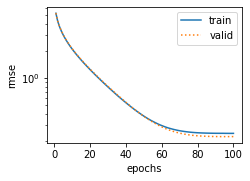

In [29]:
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

# 预测结果

In [30]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    basic.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('Datasets/KaggleHouse//submission.csv', index=False)

train rmse 0.229570


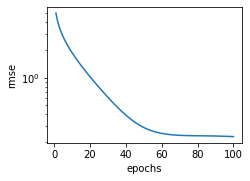

In [31]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)